<a href="https://colab.research.google.com/github/notillus47/ComputerVision20212/blob/main/%EC%BB%B4%EB%B9%84%EC%A0%84_%EB%A9%94%EA%B0%80Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 20161553 박현영 컴퓨터비전 메가 homework

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 압축파일 풀기
!unzip /content/drive/MyDrive/archive2.zip

Archive:  /content/drive/MyDrive/archive2.zip
   creating: lung/
   creating: lung/chest_xray/
   creating: lung/chest_xray/test/
   creating: lung/chest_xray/test/normal/
  inflating: lung/chest_xray/test/normal/IM-0001-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0003-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0005-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0006-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0007-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0009-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0010-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0011-0001-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0011-0001-0002.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0011-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0013-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0015-0001.jpeg  
  inflating: lung/chest_xray/test/normal/IM-0016-0001.jpeg  
  inflating: lung/chest_x

In [4]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [5]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['pneumonia', 'normal']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
ls

drive/  lung/  sample_data/


In [7]:
cd lung

/content/lung


In [8]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [9]:
print(train[3][0])

[[12 12 12 ... 53 52 51]
 [11 11 10 ... 50 52 52]
 [ 9  9  9 ... 55 54 58]
 ...
 [24 24 23 ... 46 37 37]
 [24 24 23 ... 39 37 37]
 [24 23 23 ... 36 36 38]]


In [10]:
train.shape

(400, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


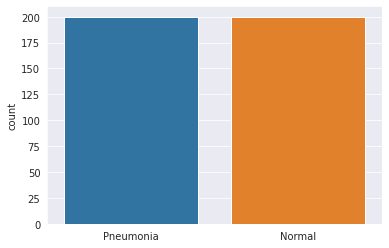

In [12]:
#폐렴과 정상 데이터의 갯수 확인하기
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

In [13]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [14]:
# 데이터를 Normalize 0~255     0~1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [15]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [17]:
# 모델을 만들기
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [18]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
13/13 [==============================] - 26s 2s/step - loss: 3.2361 - accuracy: 0.7600 - val_loss: 4.3797 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
13/13 [==============================] - 24s 2s/step - loss: 0.4632 - accuracy: 0.8525 - val_loss: 7.4290 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
13/13 [==============================] - 23s 2s/step - loss: 0.2970 - accuracy: 0.8800 - val_loss: 10.4511 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
13/13 [==============================] - 23s 2s/step - loss: 0.3667 - accuracy: 0.8725 - val_loss: 11.8654 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/12
13/13 [==============================] - 23s 2s/step - loss: 0.3578 - accuracy: 0.8575 - val_loss: 15.7090 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/12
13/13 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8925
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
13/13 [==============================] - 23s 2s/step - loss: 0

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

4/4 [==============================] - 2s 275ms/step - loss: 19.5647 - accuracy: 0.5000
Loss of the model is -  19.564651489257812
4/4 [==============================] - 1s 265ms/step - loss: 19.5647 - accuracy: 0.5000
Accuracy of the model is -  50.0 %


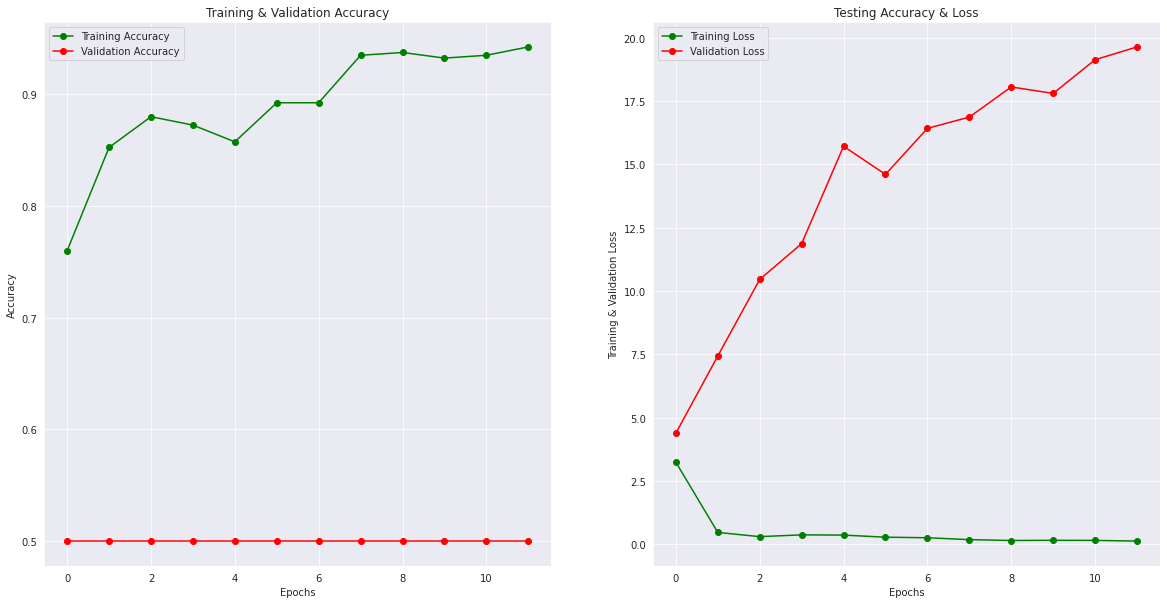

In [21]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
model.save("model1.h5")

In [23]:
from tensorflow.keras.datasets import mnist
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf

In [24]:
# Pretrained-Model                

In [25]:
model = keras.models.load_model("model1.h5")

In [26]:
# Freeze all model layer weights
model.trainable = False

# Can also set trainable for specific layers
for layer in model.layers:
    # assert should be true because of one-liner above
    assert layer.trainable == False
    layer.trainable = False

print(model.summary())  # for finding base input and output
base_inputs = model.layers[0].input
base_output = model.layers[-2].output
output = layers.Dense(2)(base_output)
new_model = keras.Model(base_inputs, output)

# This model is actually identical to model we
# loaded (this is just for demonstration and
# and not something you would do in practice).
print(new_model.summary())

# As usual we do compile and fit, this time on new_model
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

newmodel = new_model.fit(x_train, y_train, batch_size=32, epochs=15, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

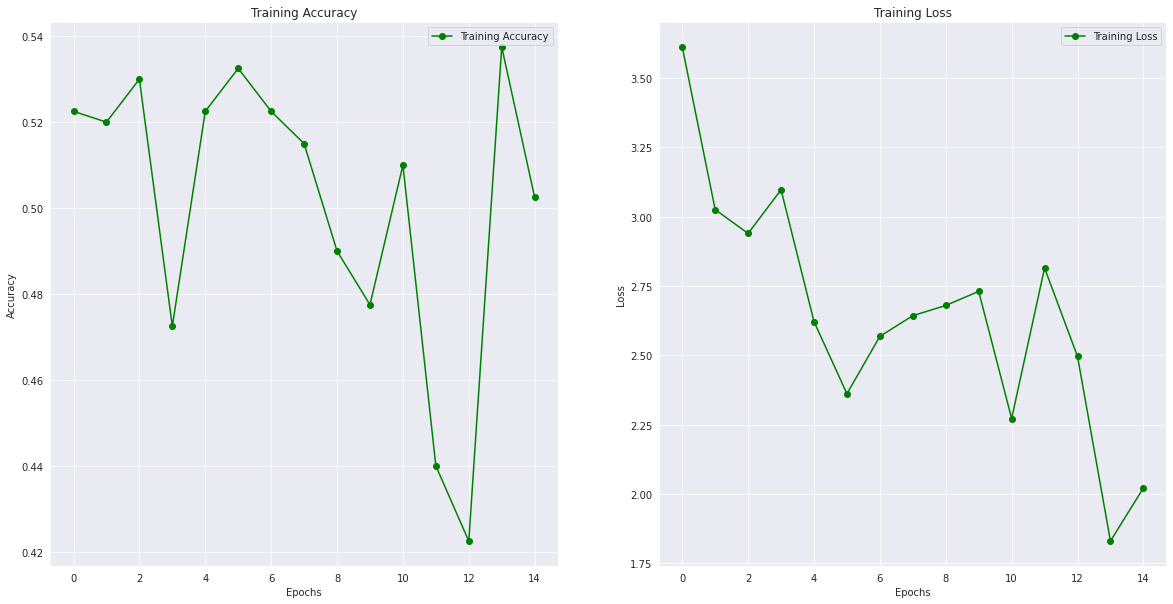

In [27]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = newmodel.history['accuracy']
train_loss = newmodel.history['loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [28]:
test_loss, test_acc = new_model.evaluate(x_test,y_test)
print('Test accuracy :', test_acc*100, "%")

4/4 [==============================] - 2s 361ms/step - loss: 1.0028 - accuracy: 0.5000
Test accuracy : 50.0 %
